In [76]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from collections import Counter
import scipy
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.cm import ScalarMappable
from sklearn import metrics
import gget
import tabulate
from sklearn.neighbors import BallTree
from scipy.stats import gmean
import matplotlib.ticker as ticker
import sys


# locals
sys.path.append('../')
import utils as ut

In [2]:
cardDir =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/CARDInputs/"
xyPath =  "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/combinedEmbedding.csv"
xy = pd.read_csv(xyPath)
cTypes = sorted(list(xy['cellTypes'].unique()))
xy['metaTypes'] = xy['cellTypes']
print(cTypes)
print()

keys = ['ND', 'HFD8', 'HFD14']

rna = {}
labels = {}

for key in keys:
    print(f"{key}...")
    labelPath = f"{cardDir}{key}_macrophage_clusters.csv"
    lf = pd.read_csv(labelPath)
    
    lf = pd.merge(lf, xy[['x', 'y', 'cellId', 'colors', 'metaTypes']], 
                  how='left',
                  left_on='cellId',
                  right_on='cellId')
    
    labels[key] = lf
    
    rnaPath = f"{cardDir}{key}_macrophage_rna.csv"
    rf = pd.read_csv(rnaPath)
    rf = rf.T
    new_header = rf.iloc[0] 
    rf = rf[1:] 
    rf.columns = new_header 
    rf.index.names = ['cellId']
    
    rf = ut.normalize(rf, 1e6)
    
    rna[key] = rf

print('done')

['B cells', 'Dendritic cells', 'Macrophages', 'Monocytes', 'NK cells', 'Stromal cells', 'T cells']

ND...
HFD8...


IOStream.flush timed out


HFD14...
done


In [3]:
rdf = []
meta = []

for key in ['HFD8', 'HFD14']:
    # reformat the index
    rf = rna[key].copy()
    rf.index = rf.index + "_" + key
    rdf.append(rf)
    
    lf = labels[key].copy()
    lf['cellId'] = lf['cellId'] + "_" + key
    
    meta.append(lf)
    
rdf = pd.concat(rdf)
print(f"{rdf.shape=}")

meta = pd.concat(meta)
print(f"{meta.shape=}")

rdf.shape=(12559, 31053)
meta.shape=(12589, 7)


In [4]:
cellIds = meta[meta['cellType'].isin(['Mac4', 'Mac5'])]['cellId'].to_list()

mask = rdf.index.isin(cellIds)

ingroup = rdf[mask].fillna(0)
outgroup = rdf[~mask].fillna(0)

print(f"{ingroup.shape=}")
print(f"{outgroup.shape=}")

cond = {}

for key in ['HFD8', 'HFD14']:
    for ctype in ['Mac4', 'Mac5']:
        
        cids = meta[(meta['sampleInfo'] == key) & (meta['cellType'] == ctype)]['cellId'].to_list()
        
        cond[(key, ctype)] = cids
        print(f"{key=} {ctype=} {len(cids)=}")
        
        
print('done')

ingroup.shape=(4227, 31053)
outgroup.shape=(8332, 31053)
key='HFD8' ctype='Mac4' len(cids)=616
key='HFD8' ctype='Mac5' len(cids)=334
key='HFD14' ctype='Mac4' len(cids)=1413
key='HFD14' ctype='Mac5' len(cids)=1877
done


In [5]:

res = []

for i, gene in enumerate(rdf.columns):
    
    if i % 1000 == 0:
        print(f'gene {i+1}:{len(rdf.columns)}...')
    score, pval = scipy.stats.ranksums(ingroup[gene], 
                                       outgroup[gene],
                                       alternative='two-sided')

    imean = ingroup[gene].mean()
    omean = outgroup[gene].mean()
    icount = ingroup[gene].astype(bool).sum()
    ocount = outgroup[gene].astype(bool).sum()
    
    lfc = np.log2(imean + 0.001) - np.log2(omean + 0.001)
    
    row = {
        'gene' : gene,
        'score' : score,
        'pval' : pval,
        'log2foldchange' : lfc,
        'ingroupMean' : imean,
        'outgroupMean' : omean,
        'ingroupCount' : icount,
        'outgroupCount' : ocount,
        'ingroupProp' : icount / len(ingroup),
        'outgroupProp' : ocount / len(outgroup),
     }
    
#     for k, cids in cond.items():
#         colName = "_".join(k) + "Mean"
#         row[colName] = ingroup[ingroup.index.isin(v)][gene].mean()
    
    res.append(row)
    
    
res = pd.DataFrame(res)
res.head()

gene 1:31053...
gene 1001:31053...
gene 2001:31053...
gene 3001:31053...
gene 4001:31053...
gene 5001:31053...
gene 6001:31053...
gene 7001:31053...
gene 8001:31053...
gene 9001:31053...
gene 10001:31053...
gene 11001:31053...
gene 12001:31053...
gene 13001:31053...
gene 14001:31053...
gene 15001:31053...
gene 16001:31053...
gene 17001:31053...
gene 18001:31053...
gene 19001:31053...
gene 20001:31053...
gene 21001:31053...
gene 22001:31053...
gene 23001:31053...
gene 24001:31053...
gene 25001:31053...
gene 26001:31053...
gene 27001:31053...
gene 28001:31053...
gene 29001:31053...
gene 30001:31053...
gene 31001:31053...


,gene,score,pval,log2foldchange,ingroupMean,outgroupMean,ingroupCount,outgroupCount,ingroupProp,outgroupProp
0,XKR4,-0.011008,0.991217,-3.726626,0.000000,0.012238,0,1,0.000000,0.00012
1,GM1992,0.000000,1.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.00000
2,GM37381,0.000000,1.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.00000
3,RP1,0.000000,1.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.00000
4,SOX17,-0.066371,0.947083,-3.019020,0.045919,0.379333,1,8,0.000237,0.00096


In [44]:
fPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/LR/LewisLabUSCS/Mouse/Mouse-2020-Baccin-LR-pairs.xlsx"

lr = pd.read_excel(fPath, engine="openpyxl")
print(lr.shape)

lr['ligand'] = lr['Ligand.Mouse'].str.upper()
lr['receptor'] = lr['Receptor.Mouse'].str.upper()
print('done')

(2000, 8)
done


In [50]:
pdf = res.copy()

ligs = set(lr['ligand'].to_list())
recs = set(lr['receptor'].to_list())

pdf['isLigand'] = pdf['gene'].apply(lambda x: True if x in ligs else False)
pdf['isReceptor'] = pdf['gene'].apply(lambda x: True if x in recs else False)

pdf.to_csv("~/temp/mac4mac5vsallDEG.csv", index=False)

pdf.head()


,gene,score,pval,log2foldchange,ingroupMean,outgroupMean,ingroupCount,outgroupCount,ingroupProp,outgroupProp,isLigand,isReceptor
0,XKR4,-0.011008,0.991217,-3.726626,0.000000,0.012238,0,1,0.000000,0.00012,False,False
1,GM1992,0.000000,1.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.00000,False,False
2,GM37381,0.000000,1.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.00000,False,False
3,RP1,0.000000,1.000000,0.000000,0.000000,0.000000,0,0,0.000000,0.00000,False,False
4,SOX17,-0.066371,0.947083,-3.019020,0.045919,0.379333,1,8,0.000237,0.00096,False,False


In [6]:
alpha = 0.05
ntests = len(rdf.columns)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

pdf = res.sort_values(by='log2foldchange', ascending=False)
pdf = pdf[pdf['pval'] < alphaHat]
print(f"{pdf.shape=}")

pdf.head(40)

alpha=0.05 ntests=31053 1.6517969930740506e-06
pdf.shape=(6029, 10)


,gene,score,pval,log2foldchange,ingroupMean,outgroupMean,ingroupCount,outgroupCount,ingroupProp,outgroupProp
668,HTR2B,6.633171,3.285499e-11,4.892423,9.228318,0.309745,311,10,0.073575,0.001200
26732,SHISA9,7.154327,8.408419e-13,4.888062,8.504098,0.286227,335,10,0.079252,0.001200
8037,HSPB7,11.470832,1.848722e-30,4.549290,20.966750,0.894528,543,27,0.128460,0.003241
8939,OCIAD2,8.568835,1.045374e-17,4.541145,10.740771,0.460376,407,23,0.096286,0.002760
1417,PCP4L1,15.292125,8.628843e-53,4.198259,27.152527,1.478192,725,37,0.171516,0.004441
6725,ATP6V0D2,61.785476,0.000000e+00,4.048442,381.436694,23.051669,3035,451,0.718003,0.054129
10606,GPNMB,60.849630,0.000000e+00,3.963220,1500.073077,96.174556,3135,1007,0.741661,0.120859
5969,CTSK,27.996561,1.789219e-172,3.923920,382.253597,25.183607,1469,364,0.347528,0.043687
16201,ANGPT2,10.921155,9.132670e-28,3.891439,14.013486,0.943359,518,27,0.122546,0.003241
29673,LIMS2,12.512902,6.346242e-36,3.887281,19.237558,1.299123,603,49,0.142654,0.005881


alpha=0.05 ntests=31053 1.6517969930740506e-06
pdf.shape=(6029, 10)


Text(0, 0.5, 'Proportion of Mac5/Mac5 Expressing')

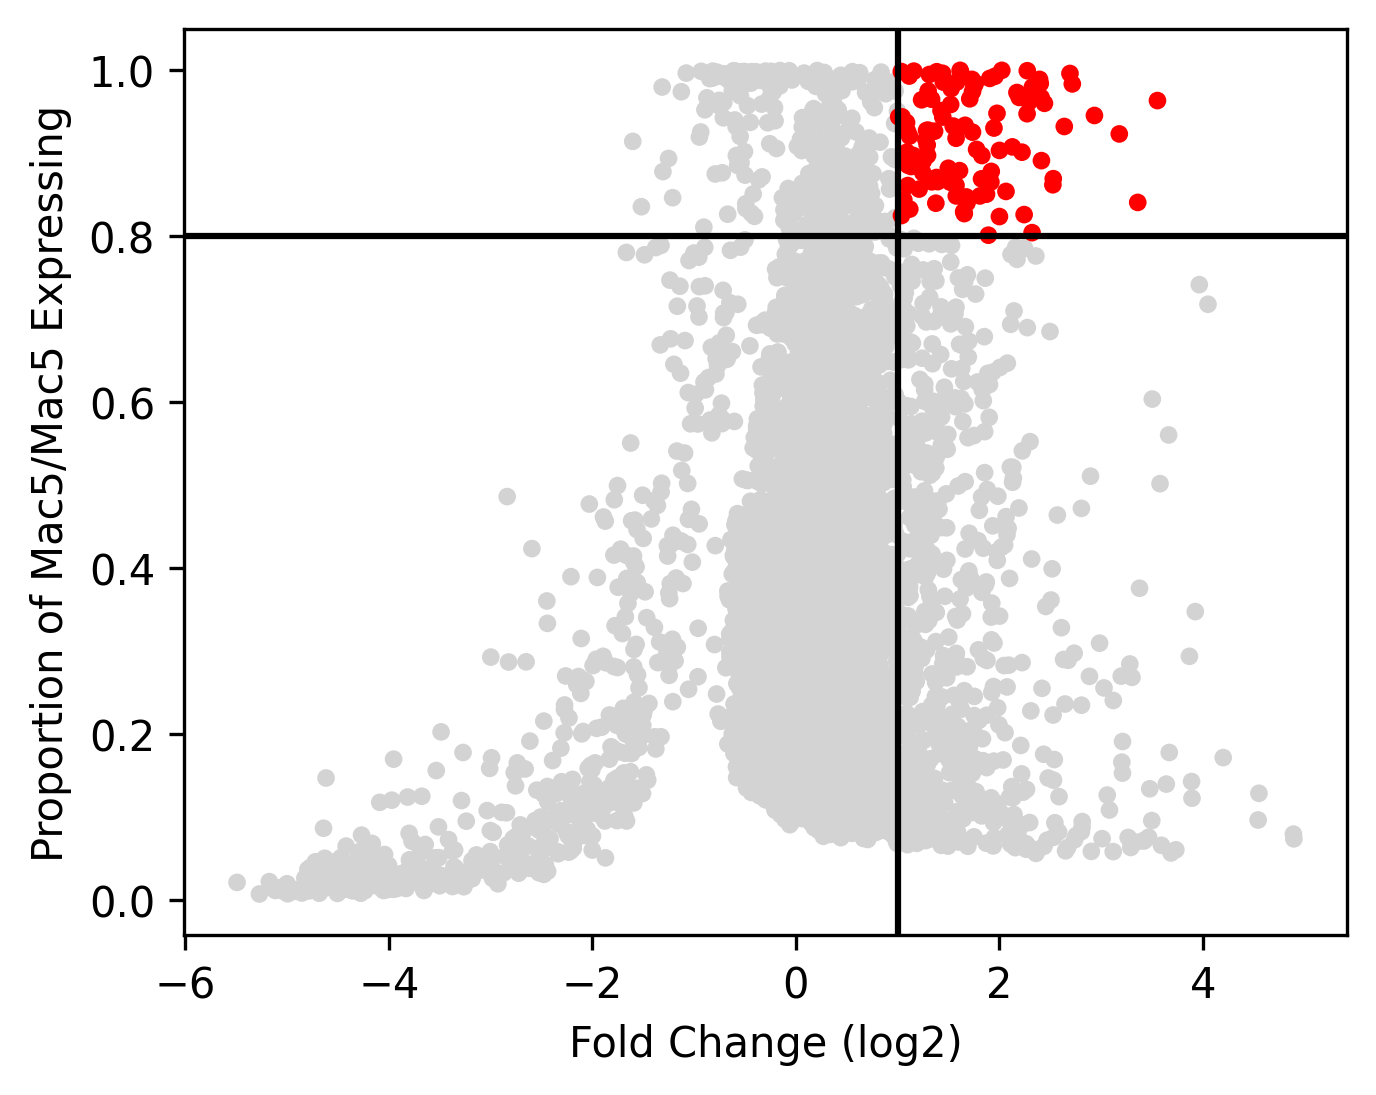

In [43]:
alpha = 0.05
ntests = len(rdf.columns)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

pdf = res.sort_values(by='log2foldchange', ascending=False)
pdf = pdf[pdf['pval'] < alphaHat]
print(f"{pdf.shape=}")


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 4
plt.rcParams['figure.facecolor'] = "w"

propT = 0.8
lftT = 1

mask = (pdf['log2foldchange'] > lftT) & (pdf['ingroupProp'] > propT)

sns.scatterplot(data=pdf[~mask], 
               x='log2foldchange',
               y='ingroupProp',
               color='lightgrey',
               size=10,
               legend=False,
               ec='None')

sns.scatterplot(data=pdf[mask], 
               x='log2foldchange',
               y='ingroupProp',
               color='r',
               size=10,
               legend=False,
               ec='None')

plt.axvline(x=lftT, c='k')
plt.axhline(y=propT, c='k')

plt.xlabel("Fold Change (log2)")
plt.ylabel("Proportion of Mac5/Mac5 Expressing")

In [118]:
alpha = 0.05
ntests = len(rdf.columns)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

pdf = res.sort_values(by='log2foldchange', ascending=False)
pdf = pdf[pdf['pval'] < alphaHat]

propT = 0.8
lftT = 1

mask = (pdf['log2foldchange'] > lftT) & (pdf['ingroupProp'] > propT)
pdf = pdf[mask]
genes = list(pdf['gene'].unique())
print(f"{pdf.shape=}")

# plot = meta[(meta['cellType'] == ctype) & (meta['sampleInfo'] == key)]

# for i, ctype in enumerate(['Mac4', 'Mac5']):
#     for j, key in enumerate(['HFD8', 'HFD14']):
#         mask = (plot['cellType'] == ctype) & (plot['sampleInfo'] == key)
#         cellIds = plot[mask]['cellId'].to_list()
        
#         # get gene expression
#         geneEx = rdf[genes].mean(axis=1).reset_index(drop=False)
#         geneEx.columns = ['cellId', 'expression']
        
        
#         plotter = pd.merge(plot, geneEx,
#                            how='left',
#                            left_on='cellId',
#                            right_on='cellId')
    
#         sns.scatterplot(data=plotter,
#                         x='x',
#                         y='y',
#                         c=plotter['expression'].to_list(),
#                         s=10,
#                         ec='k',
#                         cmap='hot')
    
        
#         break
#     break

# # mask = rdf.index.isin(cellIds)
        
# #         pass

alpha=0.05 ntests=31053 1.6517969930740506e-06
pdf.shape=(103, 10)


In [102]:
plot.head()

,cellId,cellType,sampleInfo,x,y,colors,metaTypes
1,AAACCCACACAAAGCG.1_HFD8,Mac4,HFD8,-0.985782,2.308999,#fdbf6f,Macrophages
15,AAAGAACCAACACGAG.1_HFD8,Mac4,HFD8,-1.026867,2.441957,#fdbf6f,Macrophages
17,AAAGAACCAGCGTAGA.1_HFD8,Mac4,HFD8,-0.529313,2.560354,#fdbf6f,Macrophages
26,AAAGGATGTTTCGCTC.1_HFD8,Mac4,HFD8,-0.145627,2.718960,#fdbf6f,Macrophages
30,AAAGGGCCAGAATCGG.1_HFD8,Mac4,HFD8,0.181134,-0.159540,#fdbf6f,Macrophages


Wed Mar  8 09:45:06 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


alpha=0.05 ntests=31053 1.6517969930740506e-06
pdf.shape=(103, 10)


/tmp/ipykernel_729676/4268029060.py:60: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


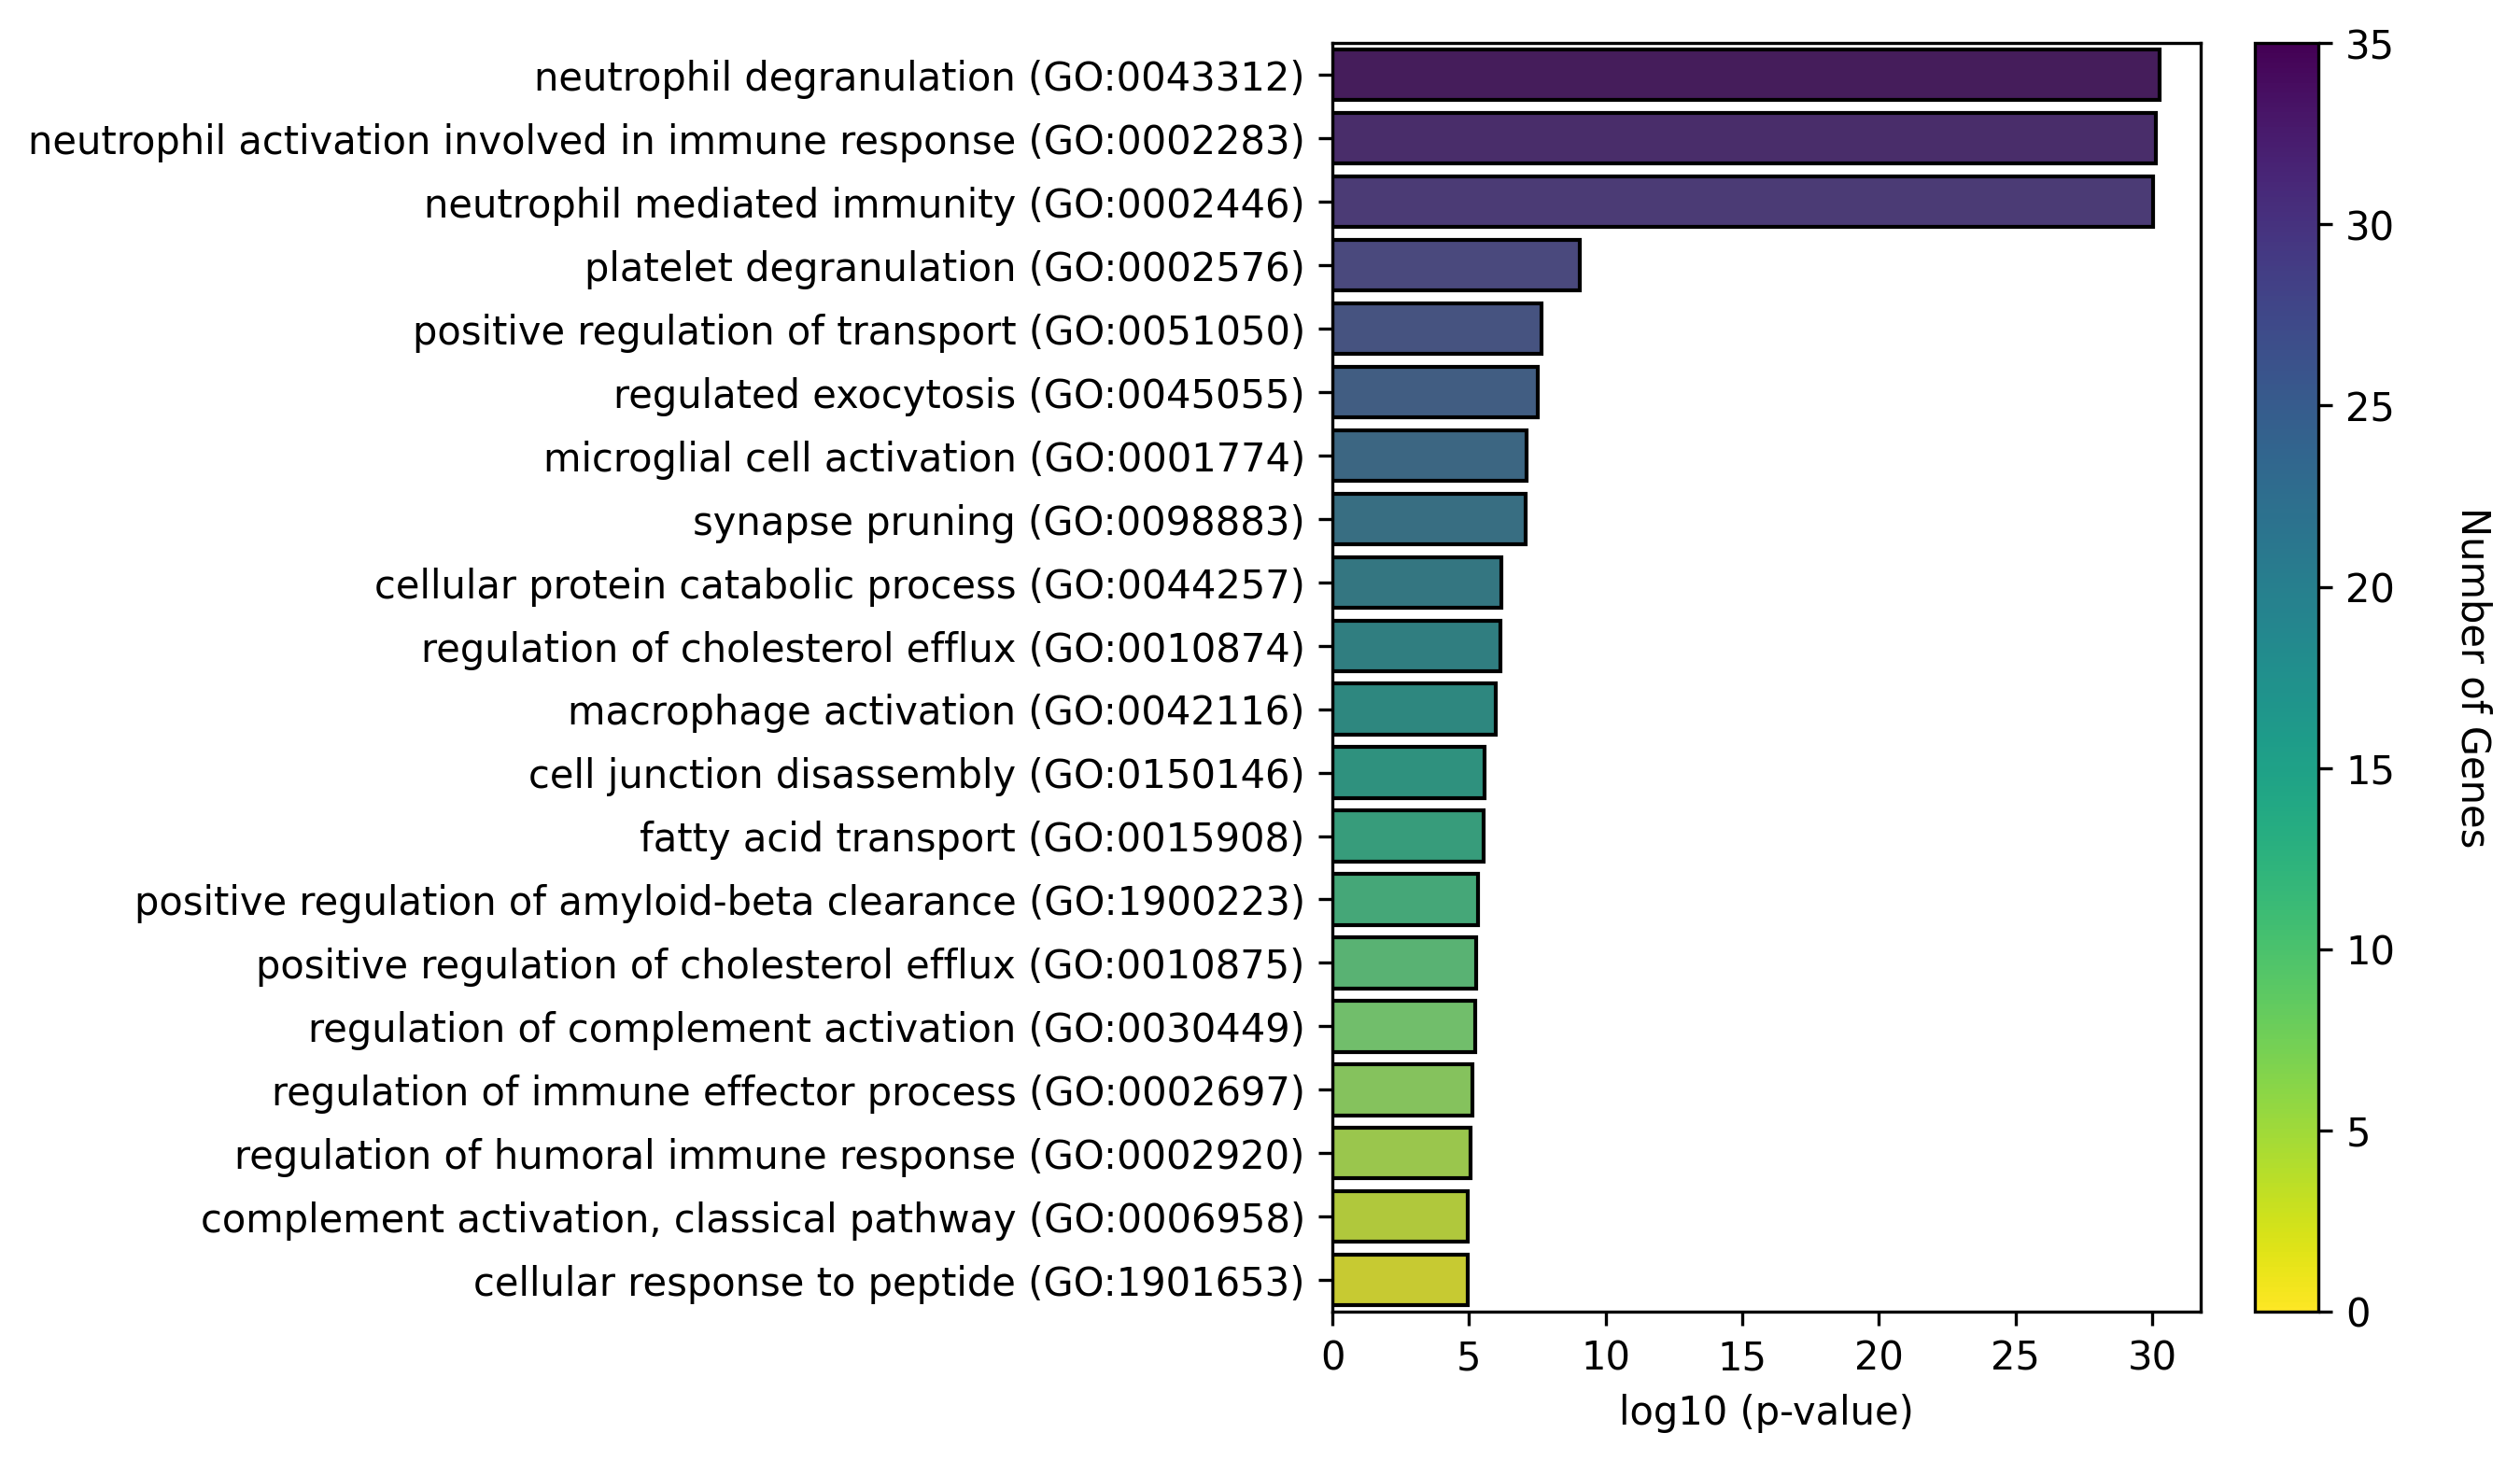

In [85]:
alpha = 0.05
ntests = len(rdf.columns)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alpha=} {ntests=} {alphaHat}")

pdf = res.sort_values(by='log2foldchange', ascending=False)
pdf = pdf[pdf['pval'] < alphaHat]


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 6
plt.rcParams['figure.facecolor'] = "w"

propT = 0.8
lftT = 1

mask = (pdf['log2foldchange'] > lftT) & (pdf['ingroupProp'] > propT)

pdf = pdf[mask]
print(f"{pdf.shape=}")

def printGSR(ef, top=None, columns=['path_name', 'overlapping_genes']):
    """A function to print pathway results """
    n = top
    if top is None:
        n = len(ef)

    ef['overlapping_genes'] = ef['overlapping_genes'].apply(lambda x: ", ".join(x))
    printDf = ef[columns].head(n)
    print(tabulate.tabulate(printDf, 
                            headers=columns, 
                            showindex=False,
                            tablefmt='orgtbl'))

genes = list(pdf['gene'].unique())


# db = 'WikiPathways_2019_Mouse'
# db = 'KEGG_2019_Mouse'
db = 'ontology'
ef = gget.enrichr(genes, database=db)
ef['logp'] = ef['p_val'].apply(lambda x: -np.log10(x))
ef['n genes'] = ef['overlapping_genes'].apply(lambda x: len(x))
ef['n genes'] = ef['n genes'].astype(float)
ef.head(10)

sns.barplot(data=ef.head(20), 
            x='logp',
            y='path_name',
            color='n genes',
            edgecolor='k',
            palette='viridis')

plt.ylabel("")
plt.xlabel("log10 (p-value)")

sm = ScalarMappable(cmap='viridis_r', norm=plt.Normalize(0,max(ef['n genes'])))
sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Number of Genes', rotation=270,labelpad=25)

# pdf.head()

In [86]:
ef.head()

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,logp,n genes
0,1,neutrophil degranulation (GO:0043312),5.474214e-31,22.447408,1564.137415,"[CD63, CSTB, ASAH1, GRN, CLEC12A, BRI3, C5AR1,...",4.070089e-28,GO_Biological_Process_2021,30.261678,35.0
1,2,neutrophil activation involved in immune respo...,7.294300e-31,22.243301,1543.530355,"[CD63, CSTB, ASAH1, GRN, CLEC12A, BRI3, C5AR1,...",4.070089e-28,GO_Biological_Process_2021,30.137016,35.0
2,3,neutrophil mediated immunity (GO:0002446),9.031262e-31,22.092585,1528.352812,"[CD63, CSTB, ASAH1, GRN, CLEC12A, BRI3, C5AR1,...",4.070089e-28,GO_Biological_Process_2021,30.044252,35.0
3,4,platelet degranulation (GO:0002576),9.123870e-10,18.496494,385.003719,"[CD63, APLP2, SELENOP, LAMP2, ANXA5, PSAP, CD9...",3.083868e-07,GO_Biological_Process_2021,9.039821,10.0
4,5,positive regulation of transport (GO:0051050),2.242828e-08,20.102980,354.072650,"[ANXA1, ANXA2, LRP1, SLC11A1, SIRPA, TREM2, CY...",6.064607e-06,GO_Biological_Process_2021,7.649204,8.0


In [8]:

fig, axs = plt.subplots(2, 2)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['figure.facecolor'] = "w"


for i, key in enumerate(['HFD8', 'HFD14']):
    for j, ctype in enumerate(['Mac4', 'Mac5']):
        
        

IndentationError: expected an indented block (4056746021.py, line 11)